# COMP 3610 - PROJECT

| UWI ID   | NAME    |
| -------- | ------- |
| `816031687` |  `RAUL ALI`   |
| `816030501` |  `JOSIAH JOEL`   |
| `816030814` |  `DAYANAND MOONOO`   |
| `816031173` |  `ZACHARY RAMPERSAD`   |

NOTES:
- Using K-Folds to validate classification metrics scores
- Expected Cleaning Time = 1:30 min

## IMPORT / READ DATA

In [60]:
# Dataframe / Visualization Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Text Cleaning Imports
import re
#!pip install emoji
import emoji
from bs4 import BeautifulSoup
import string
from string import punctuation
# from itertools import chain

# Vectorization Imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Metrics/ Utilities Imports
# from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split # KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Classification Model Imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Stopwords
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from nltk import ngrams

# Word Cloud
from wordcloud import WordCloud, STOPWORDS

# Model-Saving Imports
from joblib import dump
from joblib import load

In [61]:
# Initialize
seed_value = 42
k_folds = 5
test_size = 1/k_folds
select_percentile_value = 50

# Import data into a data frame
df=pd.read_csv("text.csv", index_col=0)
# df = pd.read_csv("https://drive.google.com/uc?export=download&id=1mQryd71hRYMLl3vzyCS9deedDQak_1LG", index_col=0)

# Print the last 5 rows to get a general idea of the dataset
df.tail()

,text,label
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3
416808,i think that after i had spent some time inves...,5


## DATA PRE-PROCESSING / CLEANING

- Removing links from the corpus
- Removing punctuation
- Removing HTML tags
- Removing Emojis
- Covert text to lowercase only
- Removing additional white spaces
- Drop duplicates

In [62]:
def clean_text(text):

    text = ' '.join(text.split()) # Remove additional white spaces
    text = emoji.demojize(text, delimiters=("", "")) # Replace emojis with word representation
    text = re.sub(r'http\S+', '', text) # Remove links
    text = text.translate(str.maketrans('', '', punctuation)) # Remove punctuation
    text = BeautifulSoup(text, "html.parser").get_text() # Remove HTML tags
    text.lower() # Convert all text to lowercase

    return text

In [63]:
# Apply the cleaning function to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# Remove duplicate text
df.drop_duplicates(subset='clean_text', keep='first', inplace=True)

In [64]:
# Drop the text feature
text_removed = df.pop('text')

# Extract the clean_text column to be moved
move_cleantext = df.pop('clean_text')

# Insert the labels after the clean_text feature column at position 1
df.insert(0, 'clean_text', move_cleantext )

From the Data Description on Kaggle, these are the perceived tone labels ascribed to the text: <br>
- (0) sadness
- (1) joy
- (2) love
- (3) anger
- (4) fear
- (5) surprise

In [65]:
# Run this code to reinsert a refreshed clean_text column
# df.drop(columns=['clean_text'], inplace=True)
# df.insert(0, 'clean_text', move_cleantext )

In [66]:
# Check the number of text samples in each tone category
df['label'].value_counts()

label
1    135030
0    118511
3     54777
4     43629
2     29468
5     12407
Name: count, dtype: int64

### UNDERSAMPLING

Sample an equal number of all review types using the minority class

In [67]:
# shuffle df before sampling
df = shuffle(df, random_state=seed_value)

# Minority class is Surprise
surp = df[df['label']==5]
print(surp.shape)

(12407, 2)


In [68]:
# Function to Undersample Classes
def undersampler(df, minority_shape):
    
    a = df[df['label']==0].head(minority_shape)
    b = df[df['label']==1].head(minority_shape)
    c = df[df['label']==2].head(minority_shape)
    d = df[df['label']==3].head(minority_shape)
    e = df[df['label']==4].head(minority_shape)

    return a,b,c,d,e

Run the Undersample

In [69]:
sad, joy,love, angr , fear = undersampler(df,surp.shape[0])

arr = [sad, joy, love, angr, fear, surp]

### Common Word Visualization using WordClouds

In [70]:
def print_cloud(data):
    stopwords_set = set(stopwords.words('english'))
    wordcloud = WordCloud(stopwords=stopwords_set, background_color="white").generate(data)
    return wordcloud

def print_cloud_categories(arr):    
      i=1
      plt.figure(figsize=(15,20))
      for item in arr:
            item_text = ' '.join(item['clean_text'])
            print ("There are {} words in category {}.".format(len(item_text), i-1))
            wordcloud = print_cloud(item_text)

            plt.subplot(6, 2, i)
            plt.imshow(wordcloud , interpolation='bilinear')
            plt.title('{} Text Sample'.format(i-1))
            plt.axis('off')
            i+=1

      plt.tight_layout()
      plt.show()

There are 1173290 words in category 0.
There are 1225595 words in category 1.
There are 1302690 words in category 2.
There are 1200728 words in category 3.
There are 1219214 words in category 4.
There are 1256769 words in category 5.


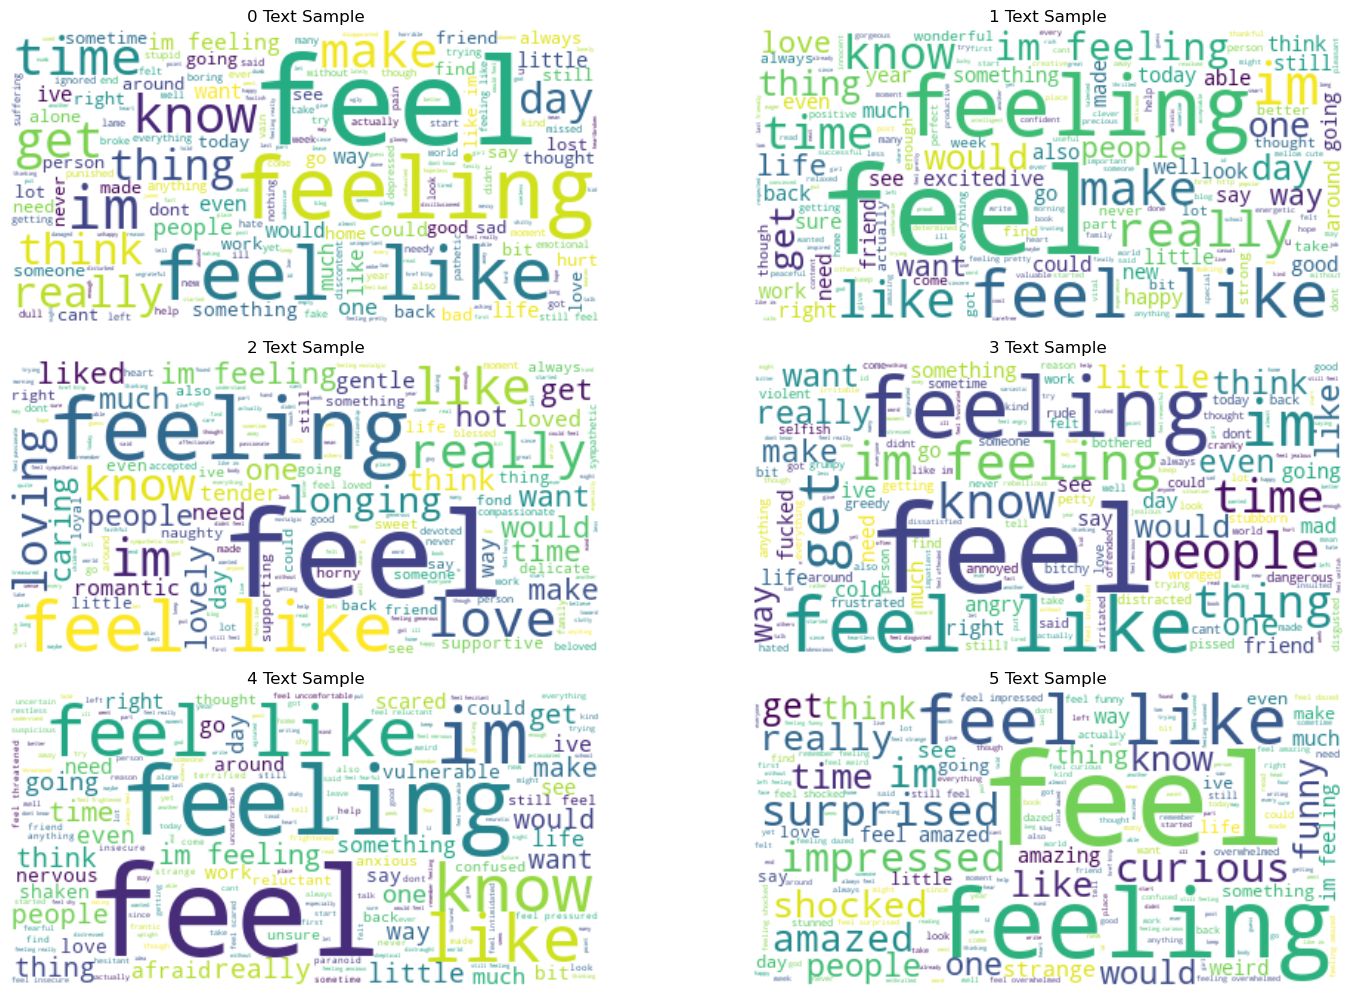

In [71]:
print_cloud_categories(arr)

### Common Word Extraction using Word Counts

In [72]:
def print_top_words(arr,vectorizer):
    i=0
    for item in arr:
        item_vect = vectorizer.fit_transform(item['clean_text'])

        item_words = vectorizer.get_feature_names_out()
        word_counts = item_vect.toarray().sum(axis=0)
        
        # Create a dictionary to store word counts
        word_count_dict = dict(zip(item_words, word_counts))

        # Sort the dictionary by counts in descending order
        sorted_word_counts = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)

        print(f'Top Words in Category {i}')
        j=1
        for word, count in sorted_word_counts[:10]:
            print(f'({j}). {word} : {count}' )
            j+=1
        print('\n')
        i+=1

In [73]:
# Count Vectorizer
countv = CountVectorizer(stop_words = 'english')

print_top_words(arr,countv)

Top Words in Category 0
(1). feel : 8551
(2). feeling : 4189
(3). like : 2260
(4). im : 1762
(5). just : 1197
(6). really : 747
(7). know : 726
(8). time : 635
(9). little : 572
(10). ive : 541


Top Words in Category 1
(1). feel : 9014
(2). feeling : 3625
(3). like : 2147
(4). im : 1794
(5). just : 928
(6). really : 718
(7). know : 634
(8). time : 633
(9). make : 506
(10). people : 464


Top Words in Category 2
(1). feel : 8676
(2). feeling : 3771
(3). like : 2717
(4). im : 1728
(5). just : 1034
(6). love : 871
(7). really : 840
(8). know : 742
(9). loved : 702
(10). loving : 695


Top Words in Category 3
(1). feel : 8227
(2). feeling : 4052
(3). like : 2207
(4). im : 2033
(5). just : 1226
(6). really : 834
(7). know : 729
(8). people : 710
(9). time : 627
(10). little : 620


Top Words in Category 4
(1). feel : 7910
(2). feeling : 4708
(3). im : 2032
(4). like : 1586
(5). just : 982
(6). little : 913
(7). know : 798
(8). really : 761
(9). time : 628
(10). bit : 601


Top Words in Cat

Observe that the words: 'feel','feeling', 'like' and 'im' are the top 4 words common amongst all classes to the same extent by wordcount. <br>
Removing common words amongst classes to reduce noise in prediction.

In [74]:
# Define common words to be removed
words_to_remove = ['feeling', 'feel', 'like', 'im']

In [75]:
# Function to remove specified words from a text
def remove_word_from_string(word, string):

    # Construct a regular expression pattern to match the word
    pattern = r'\b{}\b'.format(re.escape(word))

    # Use re.sub() to replace the matched word with an empty string
    return re.sub(pattern, '', string)


# Function to cycle through all words to remove
def remove_words(text):
    
    for word in words_to_remove:
        text = remove_word_from_string(word, text)

    return text

In [76]:
# Apply the function to the 'clean_text' column
df['clean_text'] = df['clean_text'].apply(remove_words)

Resample from the cleaned df

In [77]:
# Sample a equal number of all review types using the minority class
surp = df[df['label']==5]
sad, joy,love, angr , fear = undersampler(df,surp.shape[0])

arr = [sad, joy, love, angr, fear, surp]

# Check top words again
print_top_words(arr,countv)

Top Words in Category 0
(1). just : 1197
(2). really : 747
(3). know : 726
(4). time : 635
(5). little : 572
(6). ive : 541
(7). people : 516
(8). think : 500
(9). want : 447
(10). dont : 441


Top Words in Category 1
(1). just : 928
(2). really : 718
(3). know : 634
(4). time : 633
(5). make : 506
(6). people : 464
(7). love : 441
(8). life : 437
(9). want : 435
(10). pretty : 405


Top Words in Category 2
(1). just : 1034
(2). love : 871
(3). really : 840
(4). know : 742
(5). loved : 702
(6). loving : 695
(7). hot : 665
(8). longing : 626
(9). sympathetic : 621
(10). liked : 608


Top Words in Category 3
(1). just : 1226
(2). really : 834
(3). know : 729
(4). people : 710
(5). time : 627
(6). little : 620
(7). want : 566
(8). angry : 529
(9). think : 529
(10). dont : 477


Top Words in Category 4
(1). just : 982
(2). little : 913
(3). know : 798
(4). really : 761
(5). time : 628
(6). bit : 601
(7). people : 544
(8). want : 532
(9). scared : 515
(10). afraid : 507


Top Words in Categ

There are 1097199 words in category 0.
There are 1151988 words in category 1.
There are 1227265 words in category 2.
There are 1126562 words in category 3.
There are 1144210 words in category 4.
There are 1182381 words in category 5.


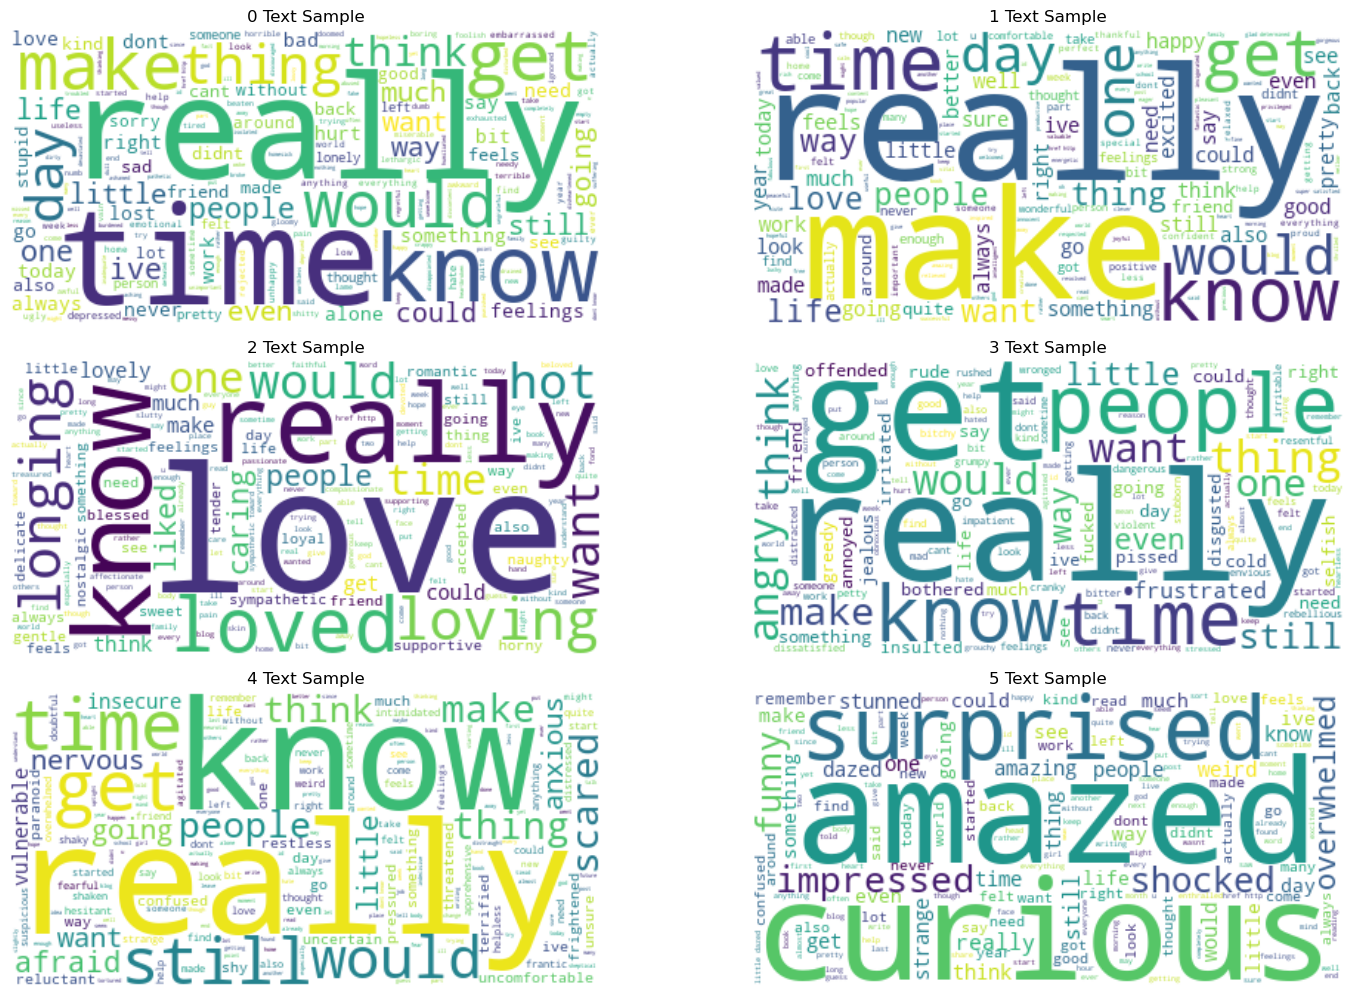

In [78]:
# Print word clouds again
print_cloud_categories(arr)

In [79]:
# Concat all Samples into one df
df_sample = pd.concat([sad,joy,love,angr,fear,surp])

# Shuffle sample df
df_sample = shuffle(df_sample , random_state=seed_value)
df_sample.reset_index(drop=True, inplace=True)

In [80]:
# Assign the clean_text field to X and df.sentiment to y
X = df_sample['clean_text']
y = df_sample['label'].values
print(X.shape)

(74442,)


## CLASSIFICATION EXPERIMENTS

### Vectorizers

In [81]:
# Count Vectorizer
countv = CountVectorizer(stop_words = 'english')

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words = 'english')

# TF-IDF Vectorizer with ngrams
tfidf_n = TfidfVectorizer(ngram_range=(1, 2), stop_words = 'english')

The function `text_fit_saver` has parameters:
- `X`: training set.
- `y`: test set.
- `vectr`: vectorizer type to be used.
- `clf`: classification model to be used.
- `select_percentile_value`: select percentile to obtain the top features of the corpus data (to reduce runtime).
- `return_model`: boolean variable to return the model
- `clf_details`: boolean variable that will show classification reports and confusion matrix.

If `return_model` is true, the function will return:

- `vectr`: the trained vectorizer.
- `clf`: the trained classification model.
- `acc`: accuracy score of the trained model.

To avoid complexity on the frontend, SelectPercentile will not be used. <br>

In [82]:
def text_fit_saver(X, y, vectr, clf, return_model=False, clf_details=True):
    X_transformed = vectr.fit_transform(X)

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=seed_value)
        
    clf.fit(X_train, y_train)

    # Predict labels on the test set
    y_pred = clf.predict(X_test)

    if(clf_details):
        print('# features in X: {}'.format(X_transformed.shape[1]))
        
        print('\nClassification Report:')
        cr = classification_report(y_test, y_pred)
        print (cr)
        
        # Generate confusion matrix
        confmat = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=clf.classes_)
        disp.plot(values_format="0.0f", cmap='PuBu')
        
    acc = accuracy_score(y_test, y_pred)
    print(f'\nAccuracy Score: {acc:.3f}')

    if(return_model):
        return  vectr, clf, acc
    
    return acc

### NEURAL NETWORKS
Multi-layer Perceptron (MLP) is a supervised learning algorithm.

In [83]:
mlpclf = MLPClassifier(random_state=seed_value) 

# List to store Accuracy scores
mlp_acc =[0]*6

In [84]:
mlpclf_1 = MLPClassifier(hidden_layer_sizes=(12,4), activation='relu', max_iter=200, random_state=seed_value) 
# 88% accuracy using tfidf

# features before applying select percentile: 33431
# features after applying select percentile: 25073

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2502
           1       0.84      0.86      0.85      2407
           2       0.91      0.90      0.91      2398
           3       0.91      0.89      0.90      2571
           4       0.87      0.86      0.86      2506
           5       0.89      0.88      0.88      2505

    accuracy                           0.88     14889
   macro avg       0.88      0.88      0.88     14889
weighted avg       0.88      0.88      0.88     14889



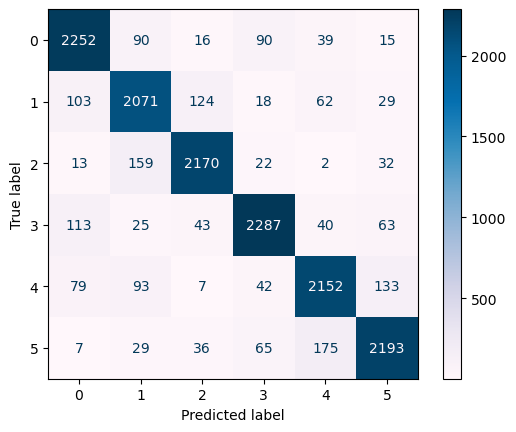

In [46]:
mlp_acc[0] = text_fit_saver(X, y, countv, mlpclf)

# features in X: 33431

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2502
           1       0.86      0.90      0.88      2407
           2       0.93      0.91      0.92      2398
           3       0.92      0.92      0.92      2571
           4       0.90      0.87      0.89      2506
           5       0.93      0.94      0.93      2505

    accuracy                           0.91     14889
   macro avg       0.91      0.91      0.91     14889
weighted avg       0.91      0.91      0.91     14889


Accuracy Score: 0.906


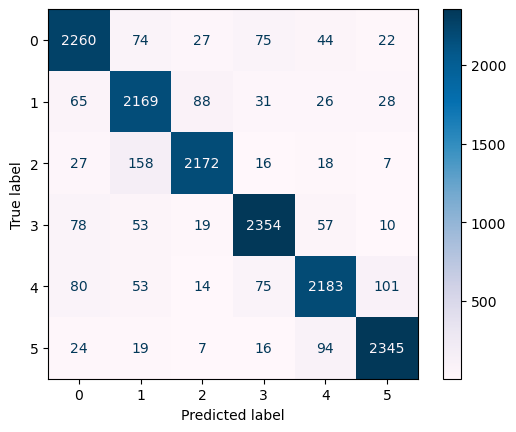

In [85]:
tfidf_for_mlp, mlp_tfidf, mlp_acc[1]  = text_fit_saver(X, y, tfidf, mlpclf, True, True)
# runtime = 30 mins

In [86]:
# Save trained models using joblib
dump(mlp_tfidf, 'mlp_tfidf.joblib')
dump(tfidf_for_mlp, 'tfidf_for_mlp.joblib')

['tfidf_for_mlp.joblib']

# features in X: 33431

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.80      2502
           1       0.77      0.80      0.79      2407
           2       0.89      0.83      0.86      2398
           3       0.88      0.84      0.86      2571
           4       0.84      0.84      0.84      2506
           5       0.84      0.83      0.84      2505

    accuracy                           0.83     14889
   macro avg       0.83      0.83      0.83     14889
weighted avg       0.83      0.83      0.83     14889


Accuracy Score: 0.830


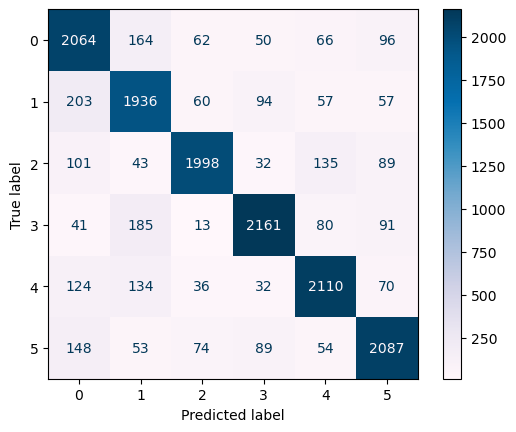

In [93]:
mlp_acc[3]  = text_fit_saver(X, y, tfidf, mlpclf_1) # Check with a 2 level hidden layer mlp
# runtime = 10mins

c:\Users\dayan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


# features in X: 376348

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2502
           1       0.89      0.92      0.90      2407
           2       0.93      0.94      0.94      2398
           3       0.94      0.93      0.94      2571
           4       0.90      0.90      0.90      2506
           5       0.94      0.92      0.93      2505

    accuracy                           0.92     14889
   macro avg       0.92      0.92      0.92     14889
weighted avg       0.92      0.92      0.92     14889


Accuracy Score: 0.922


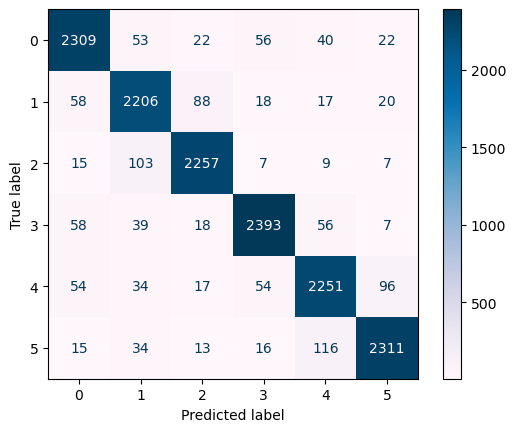

In [94]:
mlp_acc[2] = text_fit_saver(X, y, tfidf_n, mlpclf)
# run for 110mins

### RANDOM FOREST

We will compare the performance of an MLP to a Random Forest Algorithm.

In [87]:
randforest = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=seed_value)

randf_acc = [0]*3

# features before applying select percentile: 33431
# features after applying select percentile: 25073

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      2502
           1       0.95      0.89      0.92      2407
           2       0.92      0.97      0.95      2398
           3       0.93      0.94      0.94      2571
           4       0.93      0.90      0.91      2506
           5       0.92      0.97      0.95      2505

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889



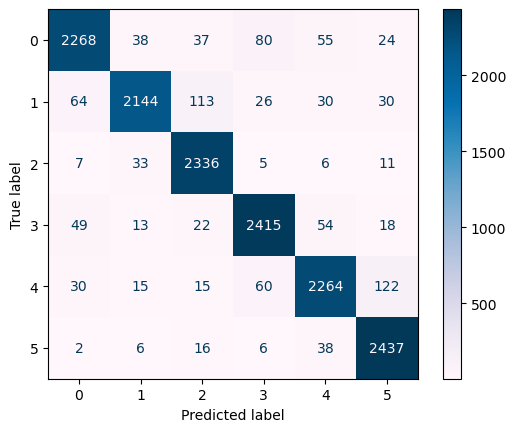

In [ ]:
randf_acc[0] = text_fit_saver(X, y, countv, randforest)
# Runtime = 5 mins

# features in X: 33431

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      2502
           1       0.96      0.89      0.92      2407
           2       0.92      0.98      0.95      2398
           3       0.93      0.94      0.93      2571
           4       0.93      0.90      0.92      2506
           5       0.92      0.98      0.95      2505

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889


Accuracy Score: 0.933


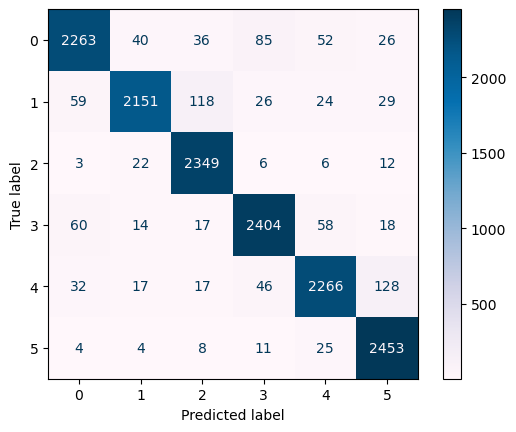

In [88]:
tfidf_for_randf, randf_tfidf, randf_acc[1] = text_fit_saver(X, y, tfidf, randforest, True)
# runtime = 5 mins

# features before applying select percentile: 376348
# features after applying select percentile: 282261

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2502
           1       0.94      0.91      0.92      2407
           2       0.93      0.97      0.95      2398
           3       0.93      0.93      0.93      2571
           4       0.93      0.90      0.91      2506
           5       0.93      0.97      0.95      2505

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889



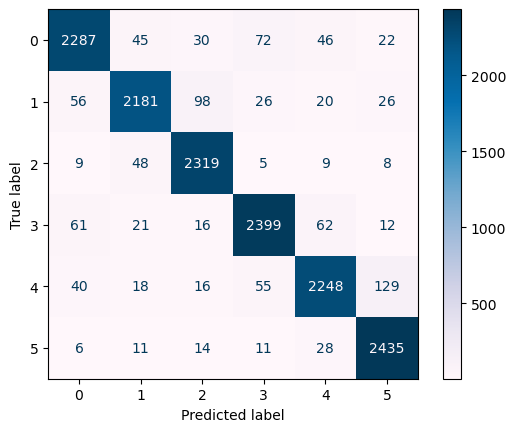

In [31]:
tfidf_n_for_randf, randf_tfidf_n, randf_acc[2] = text_fit_saver(X, y, tfidf_n, randforest, True)
# runtime = 50 mins

There is no benefit to the computing complexity of tf_idf with ngrams when compared to tf_idf under the Random Forest Classifier.
We will save the random forest classifier with tf_idf.

In [89]:
# Save trained models using joblib
dump(randf_tfidf, 'randf_tfidf.joblib')
dump(tfidf_for_randf, 'tfidf_for_randf.joblib')

['tfidf_for_randf.joblib']

### MULTINOMIAL LOGISTIC REGRESSION

We will also compare using accuracy scores to a multinomial logistic regression classifier.

In [95]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)

# features in X: 33431

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2502
           1       0.91      0.91      0.91      2407
           2       0.93      0.96      0.95      2398
           3       0.94      0.93      0.93      2571
           4       0.93      0.90      0.91      2506
           5       0.93      0.97      0.95      2505

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889


Accuracy Score: 0.930


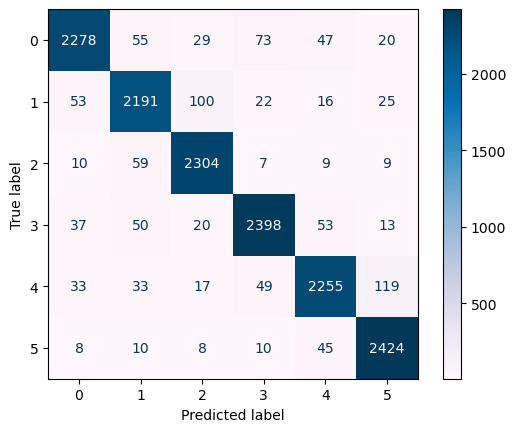

In [96]:
tfidf_for_logreg , logreg_tfidf, logreg_acc = text_fit_saver(X, y, tfidf, logreg, True)

In [97]:
# Save trained models using joblib
dump(logreg_tfidf, 'logreg_tfidf.joblib')
dump(tfidf_for_logreg, 'tfidf_for_logreg.joblib')

['tfidf_for_logreg.joblib']

### Example: Obtain the probabilities by class for any instance in df_sample

We will use the multinomial logistic regression here.

In [43]:
# Load the saved models
loaded_model = load('logreg_tfidf.joblib')
loaded_vectr = load('tfidf_for_logreg.joblib')

In [44]:
# Function to preprocess text
def preprocess_input(text):
    
    text = ' '.join(text.split())   # Remove additional white spaces
    text = re.sub(r'http\S+', '', text) # Remove links
    text = text.translate(str.maketrans('', '', punctuation)) # Remove punctuation
    text = BeautifulSoup(text, "html.parser").get_text() # Remove HTML tags
    text.lower() # Convert all text to lowercase
    
    words_to_remove = ['feeling', 'feel', 'like', 'im']
    for word in words_to_remove:
            text = remove_word_from_string(word, text)
    
    text_trans = loaded_vectr.fit_transform(text)

    return text_trans

In [58]:
# Take a random instance from df_sample
r_num = random.randint(0, len(df_sample))

X_inst = df_sample.at[r_num, 'clean_text']  
y_inst = df_sample.at[r_num, 'label']  

print(f'({r_num}). {y_inst} : {X_inst}')

X_inst_trans = loaded_vectr.transform([X_inst])

(40154). 3 : i dont know i   i am more violent


In [59]:
# Obtain the probabilities for each class
probabilities = loaded_model.predict_proba(X_inst_trans)

labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Create a dictionary to store the probabilities with labels
probabilities_dict = {}

# Iterate over the probabilities array and labels simultaneously
for label, prob in zip(labels, probabilities[0]):
    probabilities_dict[label] = prob

print(probabilities_dict)

{'sadness': 0.0006367119592073836, 'joy': 0.000531030964248911, 'love': 0.0004983736255060267, 'anger': 0.9976550090975546, 'fear': 0.0004171662793163014, 'surprise': 0.00026170807416683054}
